In [ ]:
# action space analysis starts halfway through the notebook

In [1]:
import os
import glob
import json
import collections
import numpy as np
import pandas as pd

'''
 Please modify the split names and main_folder for the dataset if necessary. 
 I assume the structure of data folder to be
 
 main_folder/split_names/task_name/trial_name/traj_data.json
'''

split_names = ["train", "valid_seen", "valid_unseen"]
main_folder = "json_2.1.0"

In [2]:
'''
read_file and load json
'''
def get_filepath_dict(output_as_txt=False): # indicate whether to output the paths as txt files
    '''
    generate a dict that maps split names to a list that contains all related json files
    return {split_name:[list_of_filepaths]}
    '''
    filename_dict = {}
    for split_name in split_names:
        folder_path = os.path.join(main_folder, split_name)
        if os.path.isdir(folder_path):
            file_paths = list(glob.glob(folder_path + '/*/*/*.json'))
            file_paths.sort()
        filename_dict[split_name] = file_paths
        if output_as_txt:
            with open(split_name+"_filepaths.txt", "w") as f:
                for file_path in file_paths:
                    f.write(file_path + "\n")
    return filename_dict # return dict with keys to be split names and values to be lists of filepaths

def read_filepath_from_txt(txt_path): # read file paths from a txt
    '''
    read filepaths as a list
    return [list_of_filepaths]
    '''
    filename_list = []
    with open(txt_path, "r") as f:
        filename_list = list(f.readlines())
    filename_list = [line.strip() for line in filename_list]
    return filename_list # return a list of filenames

def load_json(file_path): # load one json
    with open(file_path, "r") as f:
        traj_dict = json.load(f)
    return traj_dict # return the dict

def load_json_all(file_path_list): # load all json given a list of file paths
    info_all = []
    for file_path in file_path_list:
        traj_dict = load_json(file_path)
        info_all.append(traj_dict)
    return info_all # a list of dict read by json

In [3]:

'''
get basic information from the dict
'''

def get_low_level_actions(traj_dict, non_repeat=True):
    '''
    load an low_level action sequence from the dict given by json file
    return [list_of_actions], [whether_object_involved], [repeat numbers]
    
    by setting remove repeat to true, 
    we consider the single action performed continuously to be a one action, e.g.
    w/o remove repeat: [a0, a1, a1, a2, a3, a3, a3, a4]
    w/ remove repeat: [a0, a1, a2, a3, a4]
    
    '''
    action_dict_sequence = traj_dict['plan']['low_actions']
    action_sequence_raw = [action_dict['api_action']['action'] for action_dict in action_dict_sequence]
    object_involved_raw = [action_dict['discrete_action']['args']!={} for action_dict in action_dict_sequence]
    if not non_repeat:
        return action_sequence_raw, object_involved_raw, [1] * len(action_dict_sequence)
    
    action_squence_nonrepeat = []
    object_involved_nonrepeat = []
    action_repeat_number = []
    current_action = ""
    for action, object_involved in zip(action_sequence_raw, object_involved_raw):
        if action != current_action:
            action_squence_nonrepeat.append(action)
            object_involved_nonrepeat.append(object_involved)
            current_action = action
            action_repeat_number.append(1)
        else:
            action_repeat_number[-1] += 1
    return action_squence_nonrepeat, object_involved_nonrepeat, action_repeat_number

def get_high_level_actions(traj_dict):
    '''
    load an low_level action sequence from the dict given by json file
    return [a1, a2, a3, a4]
    
    '''
    action_dict_sequence = traj_dict['plan']['high_pddl']
    action_sequence = [action_dict['discrete_action']['action'] for action_dict in action_dict_sequence]
    return action_sequence

def get_all_objects(traj_dict, non_repeat=False):
    '''
    load the list of objects in the scene (not necessarily acted on)
    return [list_of_object_names]
    '''
    object_dict_list = traj_dict['scene']['object_poses']
    object_list_raw = [object_dict['objectName'].split("_")[0] for object_dict in object_dict_list]
    if not non_repeat:
        return object_list_raw
    object_list_nonrepeat = list(set(object_list_raw))
    return object_list_nonrepeat

def get_instructions(traj_dict):
    '''
    load the instructions
    return [list_of_instruction_sequences(list)], [list_of_task_description]
    '''
    ins_dict_list = traj_dict["turk_annotations"]['anns']
    high_descs = [ins_dict['high_descs'] for ins_dict in ins_dict_list]
    task_descs = [ins_dict['task_desc'] for ins_dict in ins_dict_list]
    return high_descs, task_descs

def get_task_type(traj_dict):
    return traj_dict['task_type']

def get_object_acted_on(traj_dict):
    '''
    convert a dict read from json to object acted on
    return [list_of_objects]

    '''
    action_dict_sequence = traj_dict['plan']['low_actions']
    object_list = [action_dict['api_action']['objectId'].split("|")[0] for action_dict in action_dict_sequence if action_dict['discrete_action']['args']!={}]
    return object_list

def get_object_and_bbox(traj_dict):
    '''
    convert a dict read from json to object acted on and corresponding bounding boxes
    return [(o1, bb1), (o2, bb2)]
    '''
    action_dict_sequence = traj_dict['plan']['low_actions']
    object_bb_list = [ (action_dict['api_action']['objectId'].split("|")[0],
                        action_dict['discrete_action']['args']['bbox']) 
                      for action_dict in action_dict_sequence if action_dict['discrete_action']['args']!={}]
    return object_bb_list

In [4]:
'''
get length, action/instruction
'''

def get_instruction_length(traj_dict):
    '''
    get the average number of instructions for each trial
    return float(average_number_of_length)
    '''
    ins_lists = get_instructions(traj_dict)[0]
    return sum([len(ins_list) for ins_list in ins_lists])/len(ins_lists)

def get_action_seq_length(traj_dict, low_level=True, unique = True):
    '''
    get the length of action for each trial
    return float(length_of_action_sqeuence)
    '''
    if low_level:
        action_lists = get_low_level_actions(traj_dict, unique)[0]
    else:
        action_lists = get_high_level_actions(traj_dict)
    return len(action_lists)
    
def get_instruction_to_action_ratio(traj_dict, low_level=True, unique=True):
    return get_instruction_length(traj_dict)/get_action_seq_length(traj_dict,low_level, unique = True)

In [5]:
'''
construct pairs, which might be used in calculating relationship
'''

def get_action_object_pairs(traj_dict):
    '''
    convert a dict read from json to a series of action-object pairs (an action and the object acted on)
    return [(a1, o1), (a1, o2)]
    '''
    action_dict_sequence = traj_dict['plan']['low_actions']
    action_object_pairs = [ (action_dict['api_action']['action'], action_dict['api_action']['objectId'].split("|")[0]) 
                           for action_dict in action_dict_sequence if action_dict['discrete_action']['args']!={}]
    return action_object_pairs

def get_action_action_pairs(traj_dict, low_level=True, unique=True):
    '''
    convert a dict read from json to a series of action-acton pairs (an action and the following action)
    return [(a1, a2), (a1, a3), (a2, a3)]
    '''
    if low_level:
        action_lists = get_low_level_actions(traj_dict, unique)[0]
    else:
        action_lists = get_high_level_actions(traj_dict)
    action_action_pairs = [(action_lists[i], action_lists[i+1]) for i in range(len(action_lists)) if i < (len(action_lists)-1)]
    return action_action_pairs

def get_task_action_pairs(traj_dict, low_level=True, unique=True):
    '''
    convert a dict read from json to task-acton pairs
    return [(t1, a2), (t1, a3), (t2, a1)]
    '''
    task_type = get_task_type(traj_dict)
    if low_level:
        action_lists = get_low_level_actions(traj_dict, unique)[0]
    else:
        action_lists = get_high_level_actions(traj_dict)
    return [(task_type, action) for action in action_lists]

def get_attempts_action_pairs(traj_dict, low_level=True, unique=True):
    '''
    convert a dict read from json to attempt-acton pairs
    return [(t1, a2), (t1, a3), (t2, a1)]
    '''
    trial_id = traj_dict['task_id']
    if low_level:
        action_lists = get_low_level_actions(traj_dict, unique)[0]
    else:
        action_lists = get_high_level_actions(traj_dict)
    return [(trial_id, action) for action in action_lists]

In [6]:
'''
calculate statistical information
'''

def get_pair_frequency(pair_list, normalize = True):
    '''
    convert a list of term pairs to a 2-d matrix
    input: [(t1, t2), (t1, t3), (t2, t3)]
    output: matrix, key list, value list
           t2, t3
        t1 0.5 0.5
        t2 0   0.5
        [t1, t2]
        [t2, t3]
    '''

    all_keys = list(set([pair[0] for pair in pair_list]))
    all_values = list(set([pair[1] for pair in pair_list]))
    all_keys.sort()
    all_values.sort()
    freq_matrix = np.zeros([len(all_keys), len(all_values)])
    count_dict = collections.Counter(pair_list)
    def fill_matrix(indexs):
        i_key, i_value = indexs
        pair = (all_keys[i_key], all_values[i_value])
        freq_matrix[i_key][i_value] = count_dict.get(pair, 0)
    list(map(lambda x:fill_matrix(x), [(i_key, i_value) for i_key in range(len(all_keys)) for i_value in range(len(all_values))]))
    if normalize:
        freq_matrix = freq_matrix/(np.sum(freq_matrix, axis=1, keepdims=True)+1e-7)
    return freq_matrix, all_keys, all_values

def get_frequency(name_list, normalize=True):
    '''
    convert a list of terms to a vector representing the frequency
    input: (t1, t2, t3, t1)
    output: (0.5, 0.25, 0.25), [t1, t2, t3]
    '''
    count_dict = collections.Counter(name_list)
    keys = list(count_dict.keys())
    keys.sort()
    frequency_vector = np.array([count_dict[key] for key in keys])
    if normalize:
        frequency_vector = frequency_vector/(np.sum(frequency_vector, keepdims=True)+1e-7)
    return frequency_vector, keys

In [7]:
filepaths_dict = get_filepath_dict()
train_paths = filepaths_dict['train']
val_seen_paths = filepaths_dict['valid_seen']
val_unseen_paths = filepaths_dict['valid_unseen']

In [397]:

'''
load traj dicts
'''

val_seen_traj_list = load_json_all(val_seen_paths)
val_unseen_traj_list = load_json_all(val_unseen_paths)
train_traj_list = load_json_all(train_paths)

# '''
# data analysis
# '''
# action_list = []
# for traj in val_seen_traj_list:
#     action_list.extend(get_low_level_actions(traj)[0])
# pair_freq = get_frequency(action_list, normalize = False)

In [399]:
print(len(val_seen_traj_list))
print(len(val_unseen_traj_list))
print(len(train_traj_list))

251
255
6574


## Statistics (expectation, standard deviation, max, min) on the number of actions 

### High Level 

In [187]:
# train
low_num_actions_list_train = []
high_num_actions_list_train = []

for traj in train_traj_list:
    low_num_actions_list_train.append(get_action_seq_length(traj, low_level=True, unique = False))
    high_num_actions_list_train.append(get_action_seq_length(traj, low_level=False, unique = False) - 1) #minus one because ending action token
    
low_num_actions_list_train = np.array(low_num_actions_list_train)
high_num_actions_list_train = np.array(high_num_actions_list_train)    

# seen_val

low_num_actions_list_val = []
high_num_actions_list_val = []


for traj in val_seen_traj_list:
    low_num_actions_list_val.append(get_action_seq_length(traj, low_level=True, unique = False))
    high_num_actions_list_val.append(get_action_seq_length(traj, low_level=False, unique = False) - 1) #minus one because ending action token
    
low_num_actions_list_val = np.array(low_num_actions_list_val)
high_num_actions_list_val = np.array(high_num_actions_list_val)

# unseen_val

low_num_actions_list_val_unseen = []
high_num_actions_list_val_unseen = []


for traj in val_unseen_traj_list:
    low_num_actions_list_val_unseen.append(get_action_seq_length(traj, low_level=True, unique = False))
    high_num_actions_list_val_unseen.append(get_action_seq_length(traj, low_level=False, unique = False) - 1) #minus one because ending action token
    
low_num_actions_list_val_unseen = np.array(low_num_actions_list_val_unseen)
high_num_actions_list_val_unseen = np.array(high_num_actions_list_val_unseen)


In [401]:
# Unseen Val Low-level
low_num_actions_list_val_unseen_df = pd.DataFrame(low_num_actions_list_val_unseen, columns = ['Count of Low-Level Actions'])
print(low_num_actions_list_val_unseen_df.describe().loc[["mean","std","max","min"]].to_latex())

\begin{tabular}{lr}
\toprule
{} &  Count of Low-Level Actions \\
\midrule
mean &                   46.976471 \\
std  &                   20.219062 \\
max  &                  137.000000 \\
min  &                   13.000000 \\
\bottomrule
\end{tabular}



In [402]:
# Unseen Val high-level
high_num_actions_list_val_unseen_df = pd.DataFrame(high_num_actions_list_val_unseen, columns = ['Count of High-Level Actions'])
print(high_num_actions_list_val_unseen_df.describe().loc[["mean","std","max","min"]].to_latex())

\begin{tabular}{lr}
\toprule
{} &  Count of High-Level Actions \\
\midrule
mean &                     6.156863 \\
std  &                     2.330663 \\
max  &                    14.000000 \\
min  &                     3.000000 \\
\bottomrule
\end{tabular}



In [404]:
# Train Low-level
low_num_actions_list_train_df = pd.DataFrame(low_num_actions_list_train, columns = ['Count of Low-Level Actions'])
print(low_num_actions_list_train_df.describe().loc[["mean","std","max","min"]].to_latex())

\begin{tabular}{lr}
\toprule
{} &  Count of Low-Level Actions \\
\midrule
mean &                   49.782476 \\
std  &                   24.778038 \\
max  &                  234.000000 \\
min  &                    5.000000 \\
\bottomrule
\end{tabular}



In [196]:
# Train Low-level
low_num_actions_list_train_df = pd.DataFrame(low_num_actions_list_train, columns = ['Count of Low-Level Actions'])
print(low_num_actions_list_train_df.describe().loc[["mean","std","max","min"]].to_latex())

\begin{tabular}{lr}
\toprule
{} &  Count of Low-Level Actions \\
\midrule
mean &                   49.782476 \\
std  &                   24.778038 \\
max  &                  234.000000 \\
min  &                    5.000000 \\
\bottomrule
\end{tabular}



In [197]:
# Train High-level
high_num_actions_list_train_df = pd.DataFrame(high_num_actions_list_train, columns = ['Count of High-Level Actions'])
print(high_num_actions_list_train_df.describe().loc[["mean","std","max","min"]].to_latex())

\begin{tabular}{lr}
\toprule
{} &  Count of High-Level Actions \\
\midrule
mean &                     6.513538 \\
std  &                     2.488809 \\
max  &                    19.000000 \\
min  &                     2.000000 \\
\bottomrule
\end{tabular}



In [198]:
# Val seen Low-level
low_num_actions_list_val_df = pd.DataFrame(low_num_actions_list_val, columns = ['Count of Low-Level Actions'])
print(low_num_actions_list_val_df.describe().loc[["mean","std","max","min"]].to_latex())

\begin{tabular}{lr}
\toprule
{} &  Count of Low-Level Actions \\
\midrule
mean &                   50.119522 \\
std  &                   25.609562 \\
max  &                  165.000000 \\
min  &                   12.000000 \\
\bottomrule
\end{tabular}



In [199]:
# Val seen High-level
high_num_actions_list_val_df = pd.DataFrame(high_num_actions_list_val, columns = ['Count of High-Level Actions'])
print(high_num_actions_list_val_df.describe().loc[["mean","std","max","min"]].to_latex())

\begin{tabular}{lr}
\toprule
{} &  Count of High-Level Actions \\
\midrule
mean &                     6.470120 \\
std  &                     2.620325 \\
max  &                    16.000000 \\
min  &                     3.000000 \\
\bottomrule
\end{tabular}



## Statistics (expectation, standard deviation, max, min) of number of repetitions for each action

In [202]:
#only looking at the training set and low-level actions

In [210]:
repetition_dict = {}

for traj in train_traj_list:
    
    action_pairs = get_action_action_pairs(traj, low_level=True, unique=False)
    
    for action_pair in action_pairs:
        if action_pair[0] == action_pair[1]:
            if action_pair[0] in repetition_dict.keys():
                # add one if not the first repetition
                
                repetition_dict[action_pair[0]] += 1 
            else:
                repetition_dict[action_pair[0]] = 1
    
for i in repetition_dict:
    repetition_dict[i] = repetition_dict[i] / len(train_traj_list)  

In [225]:
duplicate_df = pd.DataFrame.from_dict(repetition_dict, orient = "index", columns = ["Average duplicate count per task"]).reset_index()


In [413]:
import altair

alt.Chart(duplicate_df).mark_bar().encode(
    x='index',
    y='Average duplicate count per task'
).properties(
    width=200,
    height=120
)

alt.Chart(...)

## After collapsing repeated actions, frequency of pairs of actions following each other (A1, A2) and confusion matrix

In [416]:
pair_list = []
for traj in train_traj_list:
    pair_list.extend(get_action_action_pairs(traj, low_level=True, unique=False))
    

<AxesSubplot:>

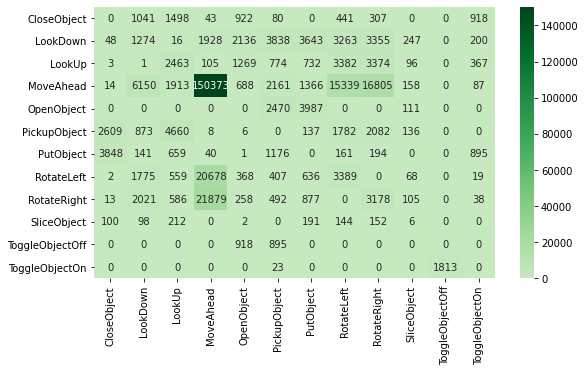

In [425]:
conf_matrix = get_pair_frequency(pair_list, normalize = False)

import seaborn as sn

setup_dp = pd.DataFrame(conf_matrix[0].astype(int), index = conf_matrix[1],
                  columns = conf_matrix[2])
plt.figure(figsize = (9,5))
sn.heatmap(setup_dp,annot=True,fmt="d", center =50000, cmap = "Greens")

## Frequency of objects acted on

In [335]:
obj_count = {}
for traj in train_traj_list:
    obj_list = get_object_acted_on(traj)
    
    for obj in obj_list:
        
        if obj in obj_count.keys():
            obj_count[obj] += 1
            #adding one to known dict keys, else setting value to 1
        else:
            obj_count[obj] = 1


In [365]:
sorted_obj_df = pd.DataFrame.from_dict(obj_count, orient = "index", columns = ["Object Count"]).sort_values("Object Count",ascending=False).reset_index()

alt.Chart(sorted_obj_df[:20]).mark_bar().encode(
    x=alt.X('index:N', sort=alt.EncodingSortField(field="Object Count", op="count", order='ascending')),
    y='Object Count'
)

alt.Chart(...)

In [363]:
all_obj_count = {}
for traj in train_traj_list:
    all_obj_list = get_all_objects(traj,non_repeat =False)
    
    for obj in all_obj_list:
        
        if obj in all_obj_count.keys():
            all_obj_count[obj] += 1
        else:
            all_obj_count[obj] = 1


In [366]:
sorted_all_obj_df = pd.DataFrame.from_dict(all_obj_count, orient = "index", columns = ["All Object Count"]).sort_values("All Object Count",ascending=False).reset_index()

alt.Chart(sorted_all_obj_df[:20]).mark_bar().encode(
    x=alt.X('index:N', sort=alt.EncodingSortField(field="All Object Count", op="count", order='ascending')),
    y='All Object Count'
)

alt.Chart(...)

In [372]:
percentage_of_obj_acted = sorted_obj_df["Object Count"].sum() / sorted_all_obj_df["All Object Count"].sum()

In [385]:
print("Percentage of objects that are used: ", round(percentage_of_obj_acted,4)*100)

Percentage of objects that are used:  19.41


## Action Object Confusion Matrix

In [427]:
pair_list = []
for traj in train_traj_list:
    pair_list.extend(get_action_object_pairs(traj))
    

<AxesSubplot:>

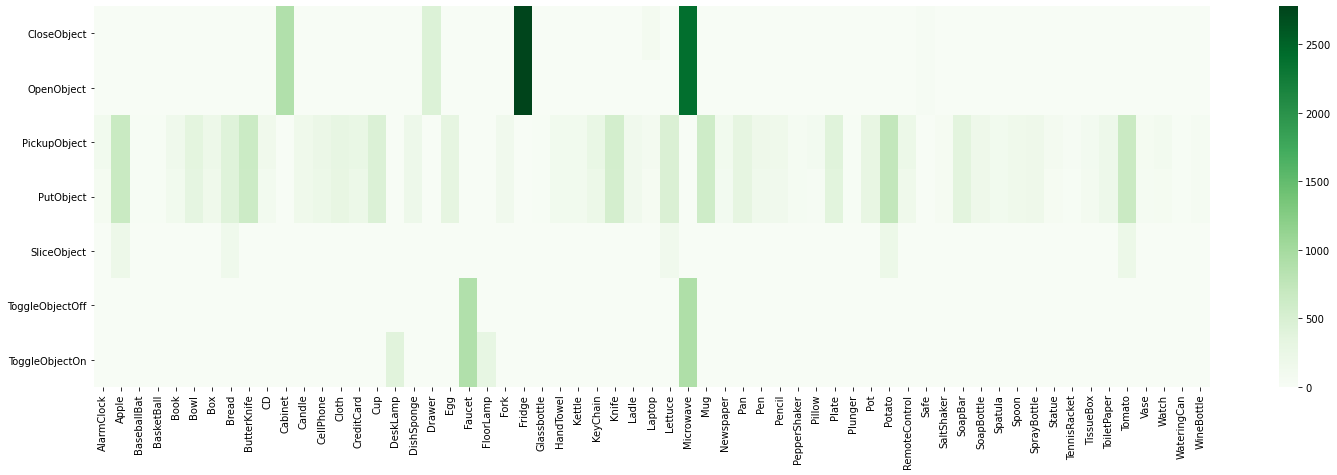

In [433]:
conf_matrix = get_pair_frequency(pair_list, normalize = False)

setup_dp = pd.DataFrame(conf_matrix[0].astype(int), index = conf_matrix[1],
                  columns = conf_matrix[2])
plt.figure(figsize = (25,7))
sn.heatmap(setup_dp,fmt="d", cmap = "Greens")